# Analyse par simulation — files d’attente (moulinette)

Deux cas étudiés :
- **Waterfall** (exécution des tests puis renvoi des résultats)
- **Channels & dams** (ING / PREPA + barrage périodique + politiques)

In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data_simulator import (
    Population,
    mmck_blocking_probability,
    simulate_channels_and_dams,
    simulate_waterfall,
    write_job_records_csv,
    write_metrics_csv,
)

sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 200)

In [2]:
def safe_div(a: float, b: float) -> float:
    return a / b if b else np.nan


def summarize_runs(run_rows: pd.DataFrame, group_cols: list[str]) -> pd.DataFrame:
    # Agrégation simple: taux agrégés et E[T] pondérée par completed
    g = run_rows.groupby(group_cols, dropna=False)

    def weighted_mean(x):
        w = x['completed'].to_numpy()
        v = x['mean_sojourn'].to_numpy()
        mask = np.isfinite(v) & (w > 0)
        if not mask.any():
            return np.nan
        return np.average(v[mask], weights=w[mask])

    out = g.agg(
        arrivals=('arrivals', 'sum'),
        accepted=('accepted', 'sum'),
        refused_stage1=('refused_stage1', 'sum'),
        stage2_refused=('stage2_refused', 'sum'),
        blank_pages=('blank_pages', 'sum'),
        permanent_blanks=('permanent_blanks', 'sum'),
        completed=('completed', 'sum'),
    ).reset_index()

    out['refused_stage1_rate'] = out['refused_stage1'] / out['arrivals']
    out['blank_pages_rate_given_accepted'] = out['blank_pages'] / out['accepted']
    out['permanent_blank_rate_given_accepted'] = out['permanent_blanks'] / out['accepted']
    out['mean_sojourn_weighted'] = g.apply(weighted_mean).to_numpy()
    return out

In [3]:
def step_series(events: list[tuple[float, int]], t_end: float | None = None):
    # events: (t, delta) -> DataFrame(t, x) pour escalier
    events = sorted(events)
    ts = [0.0]
    xs = [0]
    x = 0
    for t, d in events:
        ts.append(t)
        xs.append(x)
        x += d
        ts.append(t)
        xs.append(x)
    if t_end is not None:
        ts.append(t_end)
        xs.append(x)
    return pd.DataFrame({'t': ts, 'x': xs})


def waterfall_series_df(jobs, horizon: float) -> pd.DataFrame:
    s1_sys = []  # (t, +1/-1)
    s1_q = []
    s2_sys = []
    s2_q = []

    for j in jobs:
        if not j.accepted:
            continue
        # stage 1 system [arrival, s1_end]
        s1_sys.append((j.arrival_t, +1))
        if j.s1_end_t is not None:
            s1_sys.append((j.s1_end_t, -1))
        # stage 1 queue [arrival, s1_start]
        if j.s1_start_t is not None:
            s1_q.append((j.arrival_t, +1))
            s1_q.append((j.s1_start_t, -1))
        # stage 2 only if not refused
        if j.stage2_refused or j.s1_end_t is None:
            continue
        # stage 2 queue [s1_end, s2_start]
        if j.s2_start_t is not None:
            s2_q.append((j.s1_end_t, +1))
            s2_q.append((j.s2_start_t, -1))
        # stage 2 system [s1_end, s2_end]
        s2_sys.append((j.s1_end_t, +1))
        if j.s2_end_t is not None:
            s2_sys.append((j.s2_end_t, -1))

    parts = []
    for name, events in [('S1_system', s1_sys), ('S1_queue', s1_q), ('S2_system', s2_sys), ('S2_queue', s2_q)]:
        df = step_series(events, t_end=horizon)
        df['series'] = name
        parts.append(df)
    return pd.concat(parts, ignore_index=True)

# 1) Waterfall

In [4]:
H = 500.0
seeds = list(range(1, 21))

K = 3
mu_s = 1.0
mu_f = 2.0

ks = 20
kf = 20

lambdas = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0])
backup_p = 0.0

In [5]:
rows = []
for lam in lambdas:
    for sd in seeds:
        m, _jobs = simulate_waterfall(
            seed=int(sd), horizon=float(H), arrival_rate=float(lam),
            exec_servers=int(K), exec_service_rate=float(mu_s),
            send_service_rate=float(mu_f),
            ks=int(ks), kf=int(kf), backup_probability=float(backup_p),
        )
        rows.append({
            'lambda': float(lam),
            'seed': int(sd),
            'K': int(K),
            'mu_s': float(mu_s),
            'mu_f': float(mu_f),
            'ks': int(ks),
            'kf': int(kf),
            'backup_p': float(backup_p),
            **m.to_dict(),
        })
wf_runs = pd.DataFrame(rows)
wf_summary = summarize_runs(wf_runs, group_cols=['lambda'])
wf_summary

/tmp/ipykernel_50471/3757035513.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out['mean_sojourn_weighted'] = g.apply(weighted_mean).to_numpy()


,lambda,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted
0,0.5,5012,5012,0,0,0,0,4993,0.000000,0.000000,0.000000,1.665056
1,1.0,9963,9963,0,0,0,0,9921,0.000000,0.000000,0.000000,2.041496
2,1.5,14903,14903,0,4,4,4,14813,0.000000,0.000268,0.000268,3.175657
3,2.0,20249,20249,0,1081,1081,1081,18930,0.000000,0.053385,0.053385,7.138957
4,2.5,24816,24748,68,4333,4333,4333,19962,0.002740,0.175085,0.175085,10.296536
5,3.0,30102,28828,1274,8347,8347,8347,19866,0.042323,0.289545,0.289545,13.297098
6,4.0,39908,30484,9424,9938,9938,9938,19762,0.236143,0.326007,0.326007,16.094506


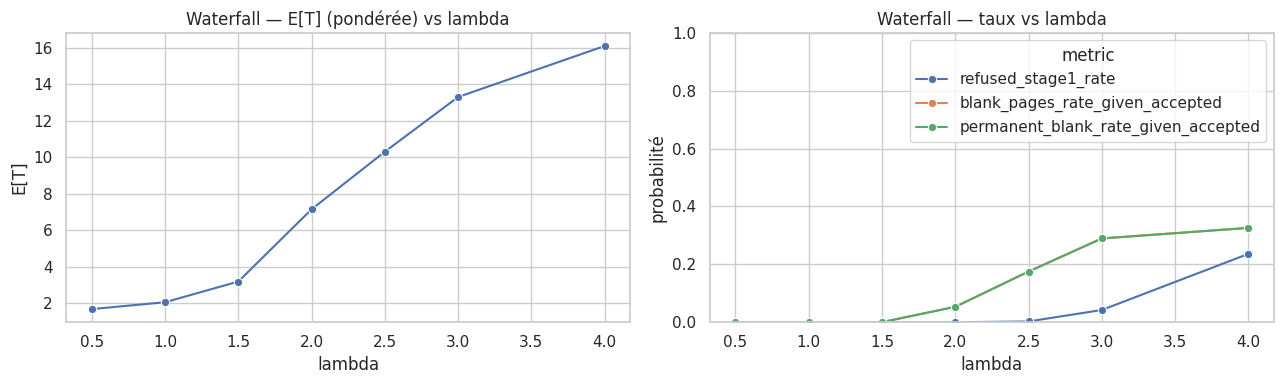

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sns.lineplot(data=wf_summary, x='lambda', y='mean_sojourn_weighted', marker='o', ax=axes[0])
axes[0].set_title('Waterfall — E[T] (pondérée) vs lambda')
axes[0].set_ylabel('E[T]')

rates = wf_summary.melt(
    id_vars=['lambda'],
    value_vars=['refused_stage1_rate', 'blank_pages_rate_given_accepted', 'permanent_blank_rate_given_accepted'],
    var_name='metric',
    value_name='rate',
)
sns.lineplot(data=rates, x='lambda', y='rate', hue='metric', marker='o', ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('Waterfall — taux vs lambda')
axes[1].set_ylabel('probabilité')

plt.tight_layout()
plt.show()

In [7]:
# Blocage théorique M/M/c/K (approx par étage)
theory = []
for lam in [1.0, 2.0, 3.0, 4.0]:
    b1 = mmck_blocking_probability(lam, mu_s, K, K + ks)
    lam_eff = lam * (1.0 - b1)
    b2 = mmck_blocking_probability(lam_eff, mu_f, 1, 1 + kf)
    theory.append({'lambda': lam, 'block_S1': b1, 'lambda_eff': lam_eff, 'block_S2': b2})
pd.DataFrame(theory)

,lambda,block_S1,lambda_eff,block_S2
0,1.0,1.738165e-11,1.000000,2.384186e-07
1,2.0,4.455636e-05,1.999911,4.543328e-02
2,3.0,4.368932e-02,2.868932,3.029847e-01
3,4.0,2.503535e-01,2.998586,3.330639e-01


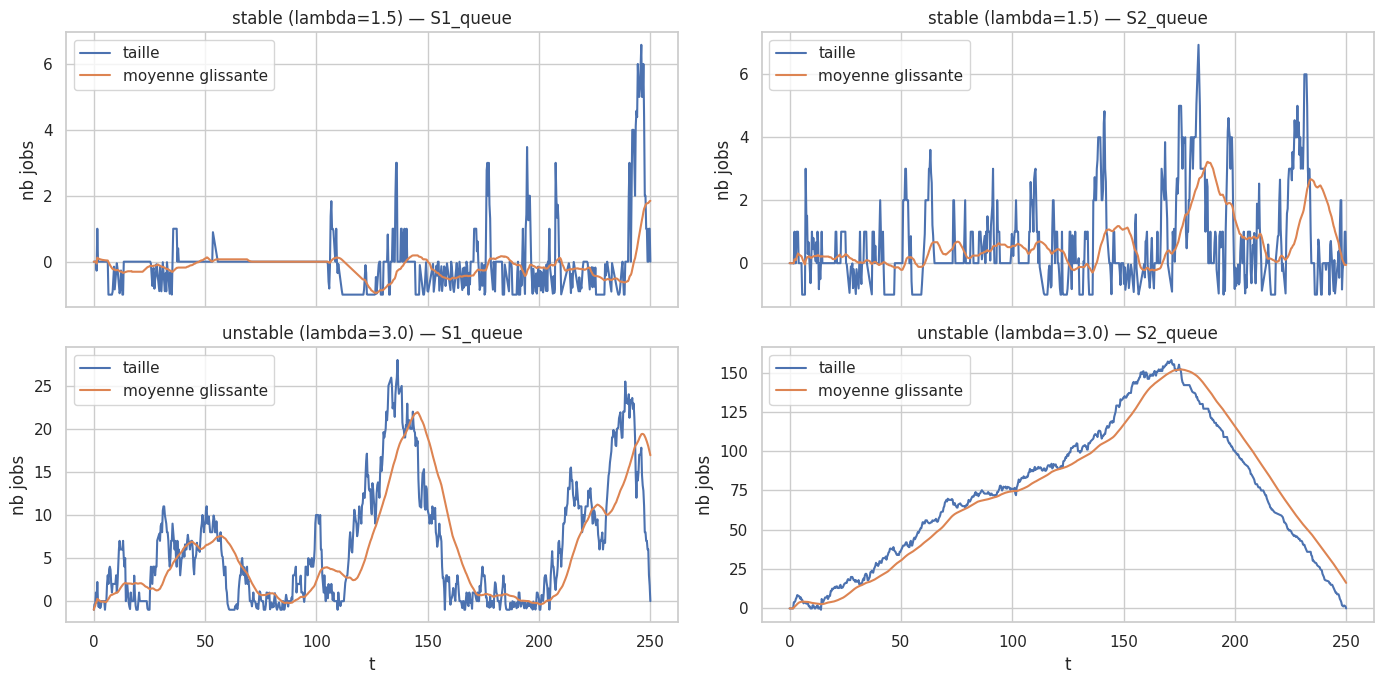

In [8]:
# Stationnarité (files infinies): comparaison stable vs instable via séries temporelles
H_ts = 250.0
K_ts = 3
mu_s_ts = 1.0
mu_f_ts = 2.0

m_st, jobs_st = simulate_waterfall(
    seed=1, horizon=H_ts, arrival_rate=1.5,
    exec_servers=K_ts, exec_service_rate=mu_s_ts,
    send_service_rate=mu_f_ts,
    ks=None, kf=None, backup_probability=0.0,
)
m_un, jobs_un = simulate_waterfall(
    seed=1, horizon=H_ts, arrival_rate=3.0,
    exec_servers=K_ts, exec_service_rate=mu_s_ts,
    send_service_rate=mu_f_ts,
    ks=None, kf=None, backup_probability=0.0,
)

df_st = waterfall_series_df(jobs_st, H_ts)
df_st['scenario'] = 'stable (lambda=1.5)'
df_un = waterfall_series_df(jobs_un, H_ts)
df_un['scenario'] = 'unstable (lambda=3.0)'
df_ts = pd.concat([df_st, df_un], ignore_index=True)

# rolling mean (sur une grille régulière) pour visualiser la convergence (ou non)
grid = np.linspace(0, H_ts, 800)

def sample_on_grid(df):
    # df: columns t, x, series, scenario ; retourne df re-échantillonné par interpolation 'forward-fill'
    out = []
    for (scenario, series), part in df.groupby(['scenario', 'series']):
        part = part.sort_values('t')
        xs = np.interp(grid, part['t'].to_numpy(), part['x'].to_numpy(), left=0, right=part['x'].iloc[-1])
        o = pd.DataFrame({'t': grid, 'x': xs, 'scenario': scenario, 'series': series})
        o['x_roll'] = pd.Series(xs).rolling(window=50, min_periods=1).mean().to_numpy()
        out.append(o)
    return pd.concat(out, ignore_index=True)

df_grid = sample_on_grid(df_ts)

fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)

for i, scenario in enumerate(['stable (lambda=1.5)', 'unstable (lambda=3.0)']):
    for j, series in enumerate(['S1_queue', 'S2_queue']):
        ax = axes[i, j]
        part = df_grid[(df_grid['scenario'] == scenario) & (df_grid['series'] == series)]
        sns.lineplot(data=part, x='t', y='x', ax=ax, label='taille')
        sns.lineplot(data=part, x='t', y='x_roll', ax=ax, label='moyenne glissante')
        ax.set_title(f"{scenario} — {series}")
        ax.set_ylabel('nb jobs')
        ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_50471/3757035513.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out['mean_sojourn_weighted'] = g.apply(weighted_mean).to_numpy()
/tmp/ipykernel_50471/3757035513.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out['mean_sojourn_weighted'] = g.apply(weighted_mean).to_numpy()


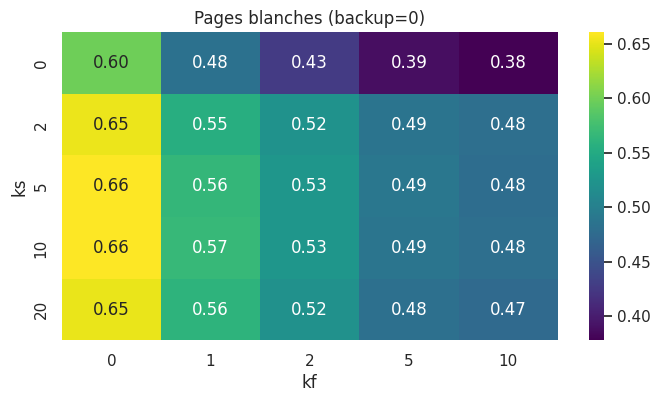

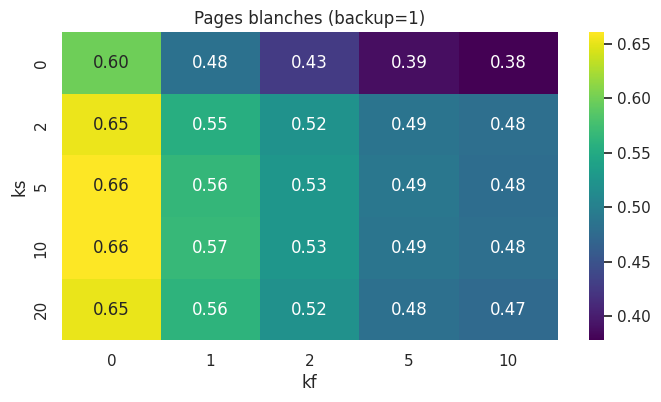

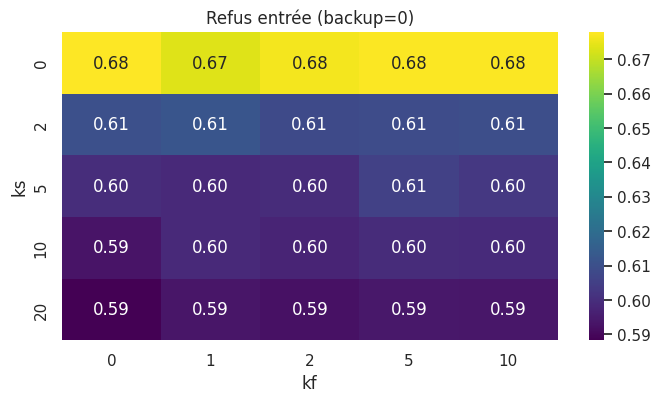

In [9]:
# Heatmap: effet (ks, kf) sur pages blanches et refus (avec/ sans backup)
H2 = 400.0
seeds2 = list(range(1, 31))
K2 = 2
mu_s2 = 1.0
mu_f2 = 1.0
lam2 = 5.0

ks_list = [0, 2, 5, 10, 20]
kf_list = [0, 1, 2, 5, 10]

def run_grid(backup_p):
    rows = []
    for ks_ in ks_list:
        for kf_ in kf_list:
            for sd in seeds2:
                m, _ = simulate_waterfall(
                    seed=int(sd), horizon=float(H2), arrival_rate=float(lam2),
                    exec_servers=int(K2), exec_service_rate=float(mu_s2),
                    send_service_rate=float(mu_f2),
                    ks=int(ks_), kf=int(kf_), backup_probability=float(backup_p),
                )
                rows.append({
                    'ks': ks_, 'kf': kf_, 'backup_p': backup_p,
                    **m.to_dict(),
                })
    df = pd.DataFrame(rows)
    s = summarize_runs(df, group_cols=['ks', 'kf', 'backup_p'])
    return s

s0 = run_grid(0.0)
s1 = run_grid(1.0)

def heatmap(df, value_col, title):
    pivot = df.pivot(index='ks', columns='kf', values=value_col).sort_index()
    plt.figure(figsize=(8, 4))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis')
    plt.title(title)
    plt.xlabel('kf')
    plt.ylabel('ks')
    plt.show()

heatmap(s0, 'blank_pages_rate_given_accepted', 'Pages blanches (backup=0)')
heatmap(s1, 'blank_pages_rate_given_accepted', 'Pages blanches (backup=1)')
heatmap(s0, 'refused_stage1_rate', 'Refus entrée (backup=0)')

In [10]:
# Export (optionnel) : métriques agrégées et un exemple de trajectoire jobs
out_dir = Path('results')
out_dir.mkdir(exist_ok=True)

wf_runs.to_csv(out_dir / 'waterfall_runs.csv', index=False)
wf_summary.to_csv(out_dir / 'waterfall_summary.csv', index=False)

m_ex, jobs_ex = simulate_waterfall(
    seed=42, horizon=H2, arrival_rate=lam2,
    exec_servers=K2, exec_service_rate=mu_s2,
    send_service_rate=mu_f2,
    ks=5, kf=2, backup_probability=0.3,
)
write_job_records_csv(out_dir / 'waterfall_jobs_seed42.csv', jobs_ex)
write_metrics_csv(out_dir / 'waterfall_metrics_seed42.csv', [m_ex])
out_dir

PosixPath('results')

# 2) Channels & dams

In [11]:
H3 = 800.0
seeds3 = list(range(1, 21))

p_ing = Population(name='ING', arrival_rate=3.0, exec_service_rate=1.5)
p_prepa = Population(name='PREPA', arrival_rate=0.6, exec_service_rate=0.5)
pops = [p_ing, p_prepa]

K3 = 3
mu_f3 = 2.0
ks3 = 30
kf3 = 30

In [12]:
def run_cd_once(seed: int, policy: str, dam_tb: float | None, split: dict[str, int] | None):
    metrics_by_pop, _jobs = simulate_channels_and_dams(
        seed=int(seed), horizon=float(H3),
        exec_servers=int(K3), send_service_rate=float(mu_f3),
        ks=int(ks3), kf=int(kf3),
        populations=pops,
        dam_tb=dam_tb, dam_population='ING',
        policy=policy, split_servers_for=split,
    )
    rows = []
    for pop_name, m in metrics_by_pop.items():
        rows.append({
            'seed': int(seed),
            'policy': policy,
            'dam_tb': dam_tb if dam_tb is not None else np.nan,
            'population': pop_name,
            **m.to_dict(),
        })
    return rows

policies = [
    ('fifo', None, None),
    ('fifo', 20.0, None),
    ('priority_ing', None, None),
    ('split_servers', None, {'ING': 2, 'PREPA': 1}),
]

rows = []
for sd in seeds3:
    for policy, dam_tb, split in policies:
        rows += run_cd_once(sd, policy, dam_tb, split)

cd_runs = pd.DataFrame(rows)
cd_summary = summarize_runs(cd_runs, group_cols=['policy', 'dam_tb', 'population'])
cd_summary

/tmp/ipykernel_50471/3757035513.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out['mean_sojourn_weighted'] = g.apply(weighted_mean).to_numpy()


,policy,dam_tb,population,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted
0,fifo,20.0,ING,47920,15669,8,28,28,28,15636,0.000167,0.001787,0.001787,6.677923
1,fifo,20.0,PREPA,9535,9532,3,8,8,8,9483,0.000315,0.000839,0.000839,6.658401
2,fifo,NaN,ING,47880,44594,3286,17887,17887,17887,25904,0.068630,0.401108,0.401108,20.609141
3,fifo,NaN,PREPA,9671,8971,700,2782,2782,2782,5986,0.072381,0.310110,0.310110,21.638535
4,priority_ing,NaN,ING,48108,45165,2943,18471,18471,18471,26109,0.061175,0.408967,0.408967,16.249348
5,priority_ing,NaN,PREPA,9779,9181,598,3068,3068,3068,5600,0.061151,0.334168,0.334168,47.089753
6,split_servers,NaN,ING,47930,41534,6396,14079,14079,14079,26872,0.133445,0.338975,0.338975,16.285110
7,split_servers,NaN,PREPA,9688,8387,1301,2610,2610,2610,5207,0.134290,0.311196,0.311196,53.494720


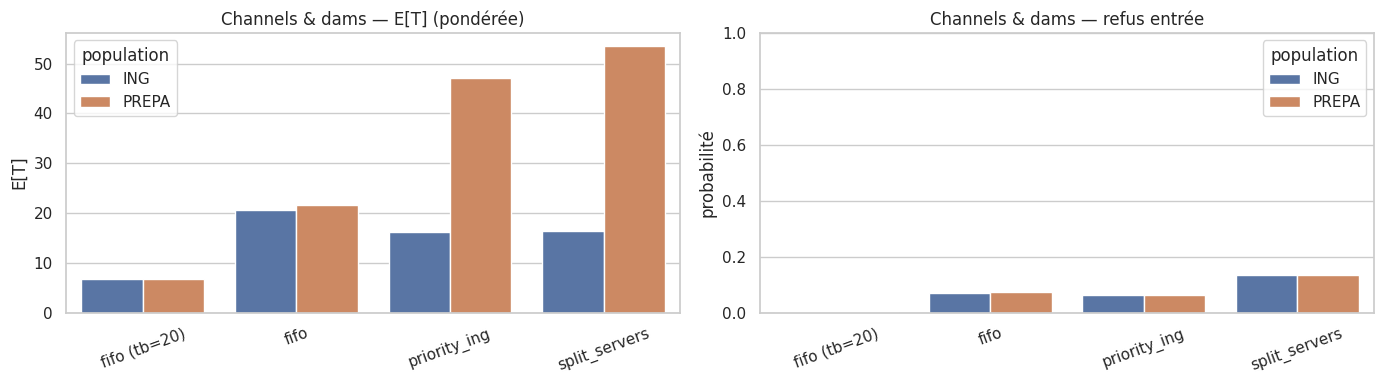

In [13]:
# Plot: E[T] par politique et population
plot_df = cd_summary.copy()
plot_df['policy_label'] = plot_df.apply(
    lambda r: f"{r['policy']} (tb={int(r['dam_tb'])})" if np.isfinite(r['dam_tb']) else str(r['policy']),
    axis=1,
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.barplot(
    data=plot_df,
    x='policy_label', y='mean_sojourn_weighted', hue='population',
    ax=axes[0]
)
axes[0].set_title('Channels & dams — E[T] (pondérée)')
axes[0].set_xlabel('')
axes[0].set_ylabel('E[T]')
axes[0].tick_params(axis='x', rotation=20)

rate_df = plot_df.copy()
rate_df['refused_stage1_rate'] = rate_df['refused_stage1_rate'].clip(0, 1)
sns.barplot(
    data=rate_df,
    x='policy_label', y='refused_stage1_rate', hue='population',
    ax=axes[1]
)
axes[1].set_ylim(0, 1)
axes[1].set_title('Channels & dams — refus entrée')
axes[1].set_xlabel('')
axes[1].set_ylabel('probabilité')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

In [14]:
# Sweep tb pour visualiser le compromis (ING) : refus vs E[T]
tb_values = [5.0, 10.0, 20.0, 40.0]
rows = []
for tb in tb_values:
    for sd in seeds3:
        metrics_by_pop, _ = simulate_channels_and_dams(
            seed=int(sd), horizon=float(H3),
            exec_servers=int(K3), send_service_rate=float(mu_f3),
            ks=int(ks3), kf=int(kf3), populations=pops,
            dam_tb=float(tb), dam_population='ING', policy='fifo',
        )
        m = metrics_by_pop['ING']
        rows.append({
            'tb': tb, 'seed': sd,
            **m.to_dict(),
        })

tb_runs = pd.DataFrame(rows)
tb_summary = summarize_runs(tb_runs, group_cols=['tb'])
tb_summary

/tmp/ipykernel_50471/3757035513.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out['mean_sojourn_weighted'] = g.apply(weighted_mean).to_numpy()


,tb,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted
0,5.0,48016,16029,0,4,4,4,16002,0.000000,0.000250,0.000250,4.291380
1,10.0,47877,15847,0,12,12,12,15755,0.000000,0.000757,0.000757,5.160675
2,20.0,47920,15669,8,28,28,28,15636,0.000167,0.001787,0.001787,6.677923
3,40.0,48696,15841,50,794,794,794,15017,0.001027,0.050123,0.050123,10.286861


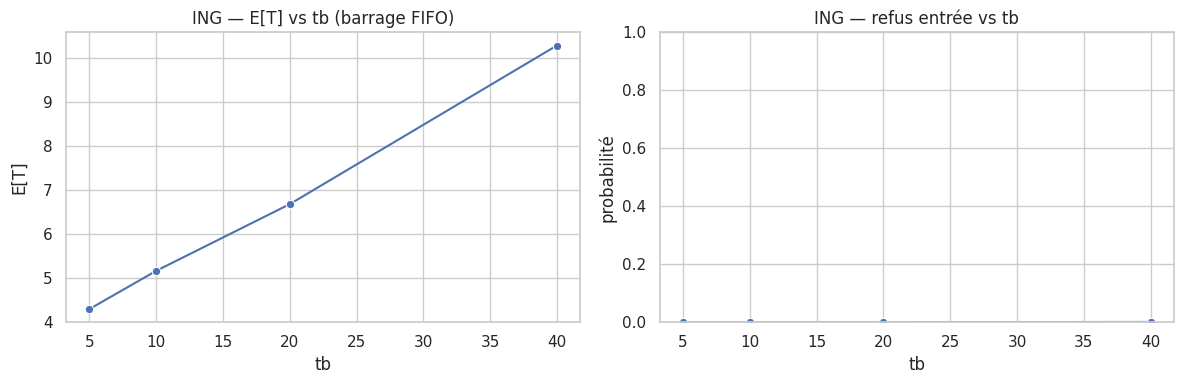

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=tb_summary, x='tb', y='mean_sojourn_weighted', marker='o', ax=ax[0])
ax[0].set_title('ING — E[T] vs tb (barrage FIFO)')
ax[0].set_ylabel('E[T]')

sns.lineplot(data=tb_summary, x='tb', y='refused_stage1_rate', marker='o', ax=ax[1])
ax[1].set_title('ING — refus entrée vs tb')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('probabilité')

plt.tight_layout()
plt.show()

In [16]:
# Export (optionnel)
out_dir = Path('results')
out_dir.mkdir(exist_ok=True)
cd_runs.to_csv(out_dir / 'channels_dams_runs.csv', index=False)
cd_summary.to_csv(out_dir / 'channels_dams_summary.csv', index=False)
tb_runs.to_csv(out_dir / 'tb_sweep_runs_ING.csv', index=False)
tb_summary.to_csv(out_dir / 'tb_sweep_summary_ING.csv', index=False)
out_dir

PosixPath('results')